#Face Detection and recognisation with Deep Learning

1. Joint Face Detection and Alignment using Multi-task Cascaded Convolutional Networks https://arxiv.org/ftp/arxiv/papers/1604/1604.02878.pdf

2. https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/

3. https://www.sitepoint.com/keras-face-detection-recognition/



Import the required packages

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.patches import Rectangle, Circle
from PIL import Image
from scipy import signal

Install the mtcnn and keras_vggface library. 

mtcnn is used for face detection and keras_vggface used for face recognisation


In [0]:
!pip install mtcnn
!pip install keras_vggface

     |████████████████████████████████| 2.3MB 3.2MB/s 


In [0]:
import mtcnn
from mtcnn.mtcnn import MTCNN
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
from scipy.spatial.distance import cosine

Using TensorFlow backend.


Mounting google dive to colab.

In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


Change the working directory to current directory

In [0]:
os.chdir('drive/My Drive/Face Detection')

In [0]:
!ls

Face_detection.ipynb  Images  Untitled0.ipynb  Untitled1.ipynb


See the licance details about mtcnn

In [0]:
pip show mtcnn

Name: mtcnn
Version: 0.1.0
Summary: Multi-task Cascaded Convolutional Neural Networks for Face Detection, based on TensorFlow
Home-page: http://github.com/ipazc/mtcnn
Author: Iván de Paz Centeno
Author-email: ipazc@unileon.es
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: keras, opencv-python
Required-by: 


In [0]:
# print version
print(mtcnn.__version__)

0.1.0


Create an detector by using default weights.

If you want to load your own weight then you can used this like: model = MTCNN(weights_file='filename.npy')

In [0]:
# create the detector, using default weights
detector = MTCNN()

*draw_image_with_boxes(filename, result_list,key_point=False)*

Will display an an image with detected face.

*filename:* input_image_name

*result_list:* data predicted by detector

*key_point:* will display extra information like, eye, nose, mouth as per key_point True/False.

In [0]:
def draw_image_with_boxes(filename, result_list,key_point=False):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        # draw the dots
        if key_point:
            for key, value in result['keypoints'].items():
            # create and draw dot
                dot = Circle(value, radius=2, color='red')
                ax.add_patch(dot)
    # show the plot
    plt.show()

*draw_faces(filename, result_list, face_return=False):*

Will display the list of face detected in an image.

*filename:* input_image_name

*result_list:* data predicted by detector

*face_return:* will return the list of face present in an image based on face_return value True/False.

In [0]:
def draw_faces(filename, result_list, face_return=False):
	# load the image
	data = plt.imread(filename)
	face_images=[]
	# plot each face as a subplot
	for i in range(len(result_list)):
		# get coordinates
		x1, y1, width, height = result_list[i]['box']
		x2, y2 = x1 + width, y1 + height
		# define subplot
		plt.subplot(1, len(result_list), i+1)
		plt.axis('off')
		# plot face
		face_image=data[y1:y2, x1:x2]
		plt.imshow(face_image)
		if face_return:
			face_image=Image.fromarray(face_image)
			face_image=face_image.resize((224,224))
			face_image=np.asarray(face_image)
			face_images.append(face_image)
	# show the plot
	plt.show()
	if face_return:
		return face_images

*blur_faces(filename, result_list)*

Will display an result with blur face.

*filename:* input_image_name

*result_list:* data predicted by detector

In [0]:
def blur_faces(filename, result_list):
    data=plt.imread(filename,cv2.IMREAD_COLOR)
    data1=np.copy(data)
    print(data1.shape)
    dim=data.shape[-1]
    for i in range(len(result_list)):
        x, y, width, height = result_list[i]['box']
        for j in range(dim):
            face=data[y:y+height,x:x+width,j]
            mask=np.ones((17,17),'float32')/(17*17)
            face=signal.convolve2d(face, mask, boundary='symm', mode='same')
            data1[y:y+height,x:x+width,j]=face
    data1=data1.astype('uint8')
    plt.imshow(data1)
    plt.show()
    plt.axis('off')

extract_face_from_image(filename):

filename: input image name

detector detect the face present in an input images and *draw_face()* collect all those faces in an list form.

In [0]:
def extract_face_from_image(filename):
    pixels = plt.imread(filename)
    # detect faces in the image
    faces = detector.detect_faces(pixels)
    # display the list of all face detected by detector and return list.
    p1=draw_faces(filename, faces,face_return=True)
    return p1 # return the list of all faces

VGGFace2 Model

In [0]:
def get_model_scores(faces):
    samples = np.asarray(faces, 'float32')

    # prepare the data for the model
    samples = preprocess_input(samples, version=2)

    # create a vggface model object
    model = VGGFace(model='resnet50',
      include_top=False,
      input_shape=(224, 224, 3),
      pooling='avg')

    # perform prediction
    return model.predict(samples)

# Face Matching

here two input images test3.jpg and test4.jpg is given. extract_face_from_image() called on both images and it return the list of face detected in both images and stored in list faces. get_model_scores(faces) is used to find the score of both faces then after cosene distance between both face is calculated if distance <0.4 then face is matched or not.

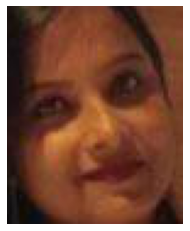

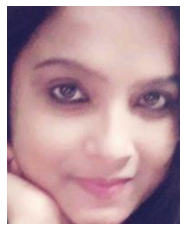

In [0]:
faces = [extract_face_from_image(image_path)[0]
         for image_path in ['./Images/test3.jpg', './Images/test4.jpg']]

In [0]:
model_scores = get_model_scores(faces)

94699520/94694792 [==============================] - 2s 0us/step


In [0]:
if cosine(model_scores[0], model_scores[1]) <= 0.4:
  print("Faces Matched")

Faces Matched


# Face Searching

This section describes the searching of an face in target images which contains multiple face.

Initialy select two images one search image and second target images. search images contains a single face, whom we are going to search in target images.

Initialy read both search and target images. Pass both images through detector to detect an face. then *draw_faces()* is called to collect the list of faces present in an both search and target images, stored in S_p and T_p, respectively.

model score for target and search image was calculated separtely. desicion was taken weather that face is present or not on the basis of cosine distance and result will be displayed with mark box.

In [0]:
Search_face='./Images/test3.jpg'
targe_image='./Images/test5.jpg'

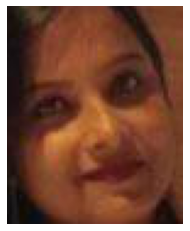

In [0]:
S = plt.imread(Search_face)
# detect faces in the image
S_faces = detector.detect_faces(S)
S_p=draw_faces(Search_face, S_faces,face_return=True)

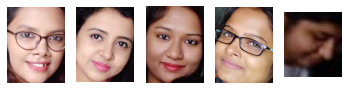

In [0]:
T = plt.imread(targe_image)
# detect faces in the image
T_faces = detector.detect_faces(T)
T_p=draw_faces(targe_image, T_faces,face_return=True)

In [0]:
S_model_scores = get_model_scores(S_p)
T_model_scores = get_model_scores(T_p)

Faces Matched


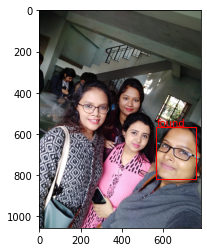

In [0]:
# load the image
data = plt.imread(targe_image)
# plot the image
plt.imshow(data)
for i in range(len(S_p)):
    for j in range(len(T_p)):
        if cosine(S_model_scores[i], T_model_scores[j]) <= 0.4:
            print("Faces Matched")
            # get the context for drawing boxes
            ax = plt.gca()
            # plot each box
            T_face = T_faces[j]
            # get coordinates
            x, y, width, height =T_face['box']
            # create the shape
            rect = Rectangle((x, y), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
            plt.text(x, y,'found',color='red')
plt.show()


# Search an face in an images with multiface

*Here both target and search image will have multiple faces. We have to find the similar face present in both images and also which face is similar to which face.*

Every things is similar to previous section. read both search and target images--> pass through the detector--> find the list of faces

Since detectore return list of dictionary. where each dictionary conatins key(box, confidance and key point) and two extra key has been added **face id** and **Match--> False** for all face both in images.

Then after model score was calculated saperately and Face matching was done on the basis of **cosine distance**. 

If match found the **Match--> False** will be change to **Match-->True** and extra key **Match_id-->id** was added in both images. Here in Search images id will be target face id and in target image id will be search face id.

Then two function was defined *draw_image_with_boxes_id(filename, result_list,key_point=False)* and *draw_image_match_boxes_id(filename, result_list,key_point=False)*. first function will display an image with their detected face and corresponding face id and second will display image with mark only those face which are present in both images.


In [0]:
Search_face='./Images/test7.jpg'
targe_image='./Images/test9.jpg'

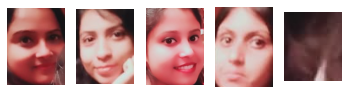

[{'box': [60, 267, 135, 179], 'confidence': 0.9999972581863403, 'keypoints': {'left_eye': (106, 342), 'right_eye': (170, 334), 'nose': (149, 375), 'mouth_left': (116, 403), 'mouth_right': (173, 397)}}, {'box': [670, 231, 91, 118], 'confidence': 0.9999145269393921, 'keypoints': {'left_eye': (691, 278), 'right_eye': (735, 272), 'nose': (711, 304), 'mouth_left': (699, 323), 'mouth_right': (737, 318)}}, {'box': [224, 373, 224, 297], 'confidence': 0.9998726844787598, 'keypoints': {'left_eye': (315, 499), 'right_eye': (412, 488), 'nose': (395, 552), 'mouth_left': (329, 603), 'mouth_right': (418, 589)}}, {'box': [540, 221, 67, 93], 'confidence': 0.9989031553268433, 'keypoints': {'left_eye': (555, 261), 'right_eye': (588, 262), 'nose': (562, 280), 'mouth_left': (553, 299), 'mouth_right': (576, 300)}}, {'box': [609, 352, 42, 50], 'confidence': 0.934152364730835, 'keypoints': {'left_eye': (626, 369), 'right_eye': (645, 372), 'nose': (635, 386), 'mouth_left': (622, 391), 'mouth_right': (636, 394)

In [0]:
S = plt.imread(Search_face)
# detect faces in the image
S_faces = detector.detect_faces(S)
S_p=draw_faces(Search_face, S_faces,face_return=True)
print(S_faces)
for i in range(len(S_faces)):
    S_faces[i]['id']=i
    S_faces[i]['match']=False
print(S_faces)

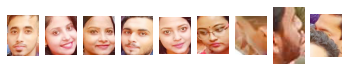

[{'box': [580, 47, 104, 132], 'confidence': 0.9999983310699463, 'keypoints': {'left_eye': (604, 101), 'right_eye': (649, 100), 'nose': (621, 127), 'mouth_left': (604, 151), 'mouth_right': (642, 151)}}, {'box': [416, 175, 88, 110], 'confidence': 0.9999953508377075, 'keypoints': {'left_eye': (447, 223), 'right_eye': (483, 211), 'nose': (478, 240), 'mouth_left': (456, 260), 'mouth_right': (494, 248)}}, {'box': [267, 129, 80, 101], 'confidence': 0.9999890327453613, 'keypoints': {'left_eye': (295, 171), 'right_eye': (332, 170), 'nose': (319, 190), 'mouth_left': (297, 205), 'mouth_right': (333, 204)}}, {'box': [656, 208, 203, 247], 'confidence': 0.9999796152114868, 'keypoints': {'left_eye': (700, 307), 'right_eye': (795, 320), 'nose': (723, 360), 'mouth_left': (689, 399), 'mouth_right': (769, 412)}}, {'box': [190, 253, 100, 120], 'confidence': 0.9999396800994873, 'keypoints': {'left_eye': (217, 304), 'right_eye': (263, 294), 'nose': (248, 324), 'mouth_left': (230, 346), 'mouth_right': (270, 

In [0]:
T = plt.imread(targe_image)
# detect faces in the image
T_faces = detector.detect_faces(T)
T_p=draw_faces(targe_image, T_faces,face_return=True)
print(T_faces)
for i in range(len(T_faces)):
    T_faces[i]['id']=i
    T_faces[i]['match']=False
print(T_faces)

In [0]:
T_faces

[{'box': [580, 47, 104, 132],
  'confidence': 0.9999983310699463,
  'id': 0,
  'keypoints': {'left_eye': (604, 101),
   'mouth_left': (604, 151),
   'mouth_right': (642, 151),
   'nose': (621, 127),
   'right_eye': (649, 100)},
  'match': False},
 {'box': [416, 175, 88, 110],
  'confidence': 0.9999953508377075,
  'id': 1,
  'keypoints': {'left_eye': (447, 223),
   'mouth_left': (456, 260),
   'mouth_right': (494, 248),
   'nose': (478, 240),
   'right_eye': (483, 211)},
  'match': False},
 {'box': [267, 129, 80, 101],
  'confidence': 0.9999890327453613,
  'id': 2,
  'keypoints': {'left_eye': (295, 171),
   'mouth_left': (297, 205),
   'mouth_right': (333, 204),
   'nose': (319, 190),
   'right_eye': (332, 170)},
  'match': False},
 {'box': [656, 208, 203, 247],
  'confidence': 0.9999796152114868,
  'id': 3,
  'keypoints': {'left_eye': (700, 307),
   'mouth_left': (689, 399),
   'mouth_right': (769, 412),
   'nose': (723, 360),
   'right_eye': (795, 320)},
  'match': False},
 {'box': [1

In [0]:
S_model_scores = get_model_scores(S_p)
T_model_scores = get_model_scores(T_p)

In [0]:
match_matrix=np.zeros((len(S_p),len(T_p)))
for i in range(len(S_p)):
    for j in range(len(T_p)):
        if cosine(S_model_scores[i], T_model_scores[j])<0.4:
            print('match found search id = {} to target id={}'.format(i,j))
            print(i)
            print(j)
            match_matrix[i,j]=1
            S_faces[i]['match_id']=j
            T_faces[j]['match_id']=i
            S_faces[i]['match']=True
            T_faces[j]['match']=True

match found search id = 0 to target id=2
0
2
match found search id = 2 to target id=1
2
1


In [0]:
T_faces[4]

{'box': [190, 253, 100, 120],
 'confidence': 0.9999396800994873,
 'id': 4,
 'keypoints': {'left_eye': (217, 304),
  'mouth_left': (230, 346),
  'mouth_right': (270, 337),
  'nose': (248, 324),
  'right_eye': (263, 294)},
 'match': True,
 'match_id': 1}

In [0]:
def draw_image_with_boxes_id(filename, result_list,key_point=False):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        x, y, width, height = result['box']
        # create the shape
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        plt.text(x+width/2,y,'id='+str(result['id']),color='red')
    # show the plot
    plt.show()

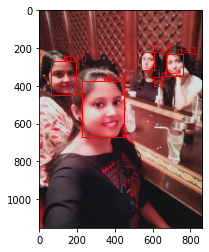

In [0]:
draw_image_with_boxes_id(Search_face,S_faces)

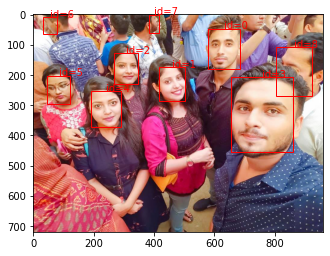

In [0]:
draw_image_with_boxes_id(targe_image,T_faces)

In [0]:
def draw_image_match_boxes_id(filename, result_list,key_point=False):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for result in result_list:
        # get coordinates
        if result['match']:
            x, y, width, height = result['box']
            # create the shape
            rect = Rectangle((x, y), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
            plt.text(x,y,'id='+str(result['id'])+'-->'+str(result['match_id']),color='red')
    # show the plot
    plt.show()

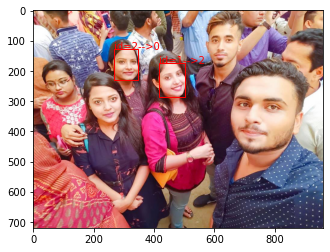

In [0]:
draw_image_match_boxes_id(targe_image,T_faces)